# Step 3: Building a Conserved Domain Model and Filtering Sequences

### Multiple Sequence Alignment (MSA) using Clustal Omega
### **Multiple Sequence Alignment (MSA) using Clustal Omega**
In this step, we align the **clustered protein sequences** from Step 2 using **Clustal Omega**.  
Multiple sequence alignment helps identify **conserved regions** within the sequences, which is essential for building models like **PSSM (Position-Specific Scoring Matrix) or HMM (Hidden Markov Models)** in later steps.

**Command Breakdown:**
- `!clustalo` → Calls **Clustal Omega** for alignment.
- `-i step2/clustered_proteins.fasta` → Specifies the **input file** containing clustered protein sequences from Step 2.
- `-o step3/aligned_proteins.fasta` → Specifies the **output file** where aligned sequences will be saved.
- `--auto` → Automatically selects alignment parameters.
- `-v` → Enables **verbose mode** for additional details.

After running this step, the **aligned sequences** will be used for further analysis, such as building **conserved region models** in the next steps.

In [173]:
!clustalo -i step2/clustered_proteins.fasta -o step3/aligned_proteins.fasta --auto -v


Using 12 threads
Read 1416 sequences (type: Protein) from step2/clustered_proteins.fasta
Setting options automatically based on input sequence characteristics (might overwrite some of your options).
Using 109 seeds (chosen with constant stride from length sorted seqs) for mBed (from a total of 1416 sequences)
Calculating pairwise ktuple-distances...
Ktuple-distance calculation progress done. CPU time: 5.47u 0.01s 00:00:05.48 Elapsed: 00:00:02
mBed created 24 cluster/s (with a minimum of 1 and a soft maximum of 100 sequences each)
Distance calculation within sub-clusters done. CPU time: 5.67u 0.01s 00:00:05.68 Elapsed: 00:00:01
Guide-tree computation (mBed) done.
Progressive alignment progress done. CPU time: 590.50u 2.11s 00:09:52.61 Elapsed: 00:01:03
Alignment written to step3/aligned_proteins.fasta


In this step, we create a BLAST database from the clustered protein sequences obtained in Step 2.
This database will be used later for searching and identifying conserved regions in the xylanase protein sequences.

In [6]:
!blastdbcmd -db xylanase_db -info


Database: step2/clustered_proteins.fasta
	1,416 sequences; 126,583 total residues

Date: Feb 8, 2025  3:36 AM	Longest sequence: 2,358 residues

BLASTDB Version: 5

Volumes:
	/home/amir/Documents/university/Semester9/bioinformatics/project2/xylanase_db


In [174]:
!makeblastdb -in step2/clustered_proteins.fasta -dbtype prot -out xylanase_db



Building a new DB, current time: 02/08/2025 03:36:58
New DB name:   /home/amir/Documents/university/Semester9/bioinformatics/project2/xylanase_db
New DB title:  step2/clustered_proteins.fasta
Sequence type: Protein
Deleted existing Protein BLAST database named /home/amir/Documents/university/Semester9/bioinformatics/project2/xylanase_db
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 1416 sequences in 0.0223091 seconds.




we read the aligned protein sequences from the multiple sequence alignment (MSA) and extract the first sequence to use as a query for further analysis.

In [175]:
from Bio import SeqIO

# Read the aligned protein sequences
records = list(SeqIO.parse("step3/aligned_proteins.fasta", "fasta"))

# Write the first sequence as the query
with open("step3/query.fasta", "w") as output_handle:
    SeqIO.write(records[0], output_handle, "fasta")

print("Query sequence saved in query.fasta")


Query sequence saved in query.fasta


### **Generating a Position-Specific Scoring Matrix (PSSM) using PSI-BLAST**
In this step, we use **PSI-BLAST** to analyze the **query sequence** against the **custom xylanase database** (`xylanase_db`) and generate a **PSSM (Position-Specific Scoring Matrix)**.

#### **Command Breakdown:**
- `!psiblast` → Calls the **PSI-BLAST** tool.
- `-db xylanase_db` → Specifies the **database** (`xylanase_db`) created in the previous step.
- `-query step3/query.fasta` → Uses the extracted **query sequence** from `step3/query.fasta`.
- `-num_iterations 3` → Runs **3 iterations** of PSI-BLAST to refine the PSSM.
- `-out_ascii_pssm xylanase.pssm` → Saves the **PSSM matrix** in a human-readable ASCII format as `xylanase.pssm`.

In [176]:
!psiblast -db xylanase_db -query step3/query.fasta -num_iterations 3 -out_ascii_pssm xylanase.pssm


PSIBLAST 2.16.0+


Reference: Stephen F. Altschul, Thomas L. Madden, Alejandro A.
Schaffer, Jinghui Zhang, Zheng Zhang, Webb Miller, and David J.
Lipman (1997), "Gapped BLAST and PSI-BLAST: a new generation of
protein database search programs", Nucleic Acids Res. 25:3389-3402.


Reference for compositional score matrix adjustment: Stephen F.
Altschul, John C. Wootton, E. Michael Gertz, Richa Agarwala,
Aleksandr Morgulis, Alejandro A. Schaffer, and Yi-Kuo Yu (2005)
"Protein database searches using compositionally adjusted
substitution matrices", FEBS J. 272:5101-5109.


Reference for composition-based statistics starting in round 2:
Alejandro A. Schaffer, L. Aravind, Thomas L. Madden, Sergei
Shavirin, John L. Spouge, Yuri I. Wolf, Eugene V. Koonin, and
Stephen F. Altschul (2001), "Improving the accuracy of PSI-BLAST
protein database searches with composition-based statistics and
other refinements", Nucleic Acids Res. 29:2994-3005.



Database: step2/clustered_proteins.fasta
           1

In this step, we process the aligned protein sequences to remove gaps ("-") introduced during multiple sequence alignment.
A cleaned query sequence is then saved for further analysis.

In [177]:
from Bio import SeqIO

# Read the aligned protein sequences
records = list(SeqIO.parse("step3/aligned_proteins.fasta", "fasta"))

# Remove gaps and ensure valid sequences
cleaned_records = []
for record in records:
    clean_seq = record.seq.replace("-", "")  # Remove all gaps
    if len(clean_seq) > 0:  # Ensure it's not empty after cleaning
        record.seq = clean_seq
        cleaned_records.append(record)

# Save the first valid sequence as query_cleaned.fasta
if cleaned_records:
    with open("step3/query_cleaned.fasta", "w") as output_handle:
        SeqIO.write(cleaned_records[0], output_handle, "fasta")
    print("Fixed query sequence saved as query_cleaned.fasta")
else:
    print("Error: No valid sequences found after removing gaps!")



Fixed query sequence saved as query_cleaned.fasta


In this step, we rerun PSI-BLAST using the cleaned query sequence (query_cleaned.fasta) to generate a PSSM (Position-Specific Scoring Matrix) while ensuring no gaps interfere with the analysis.

In [178]:
!psiblast -db xylanase_db -query step3/query_cleaned.fasta -num_iterations 3 -out_ascii_pssm step3/xylanase.pssm


PSIBLAST 2.16.0+


Reference: Stephen F. Altschul, Thomas L. Madden, Alejandro A.
Schaffer, Jinghui Zhang, Zheng Zhang, Webb Miller, and David J.
Lipman (1997), "Gapped BLAST and PSI-BLAST: a new generation of
protein database search programs", Nucleic Acids Res. 25:3389-3402.


Reference for compositional score matrix adjustment: Stephen F.
Altschul, John C. Wootton, E. Michael Gertz, Richa Agarwala,
Aleksandr Morgulis, Alejandro A. Schaffer, and Yi-Kuo Yu (2005)
"Protein database searches using compositionally adjusted
substitution matrices", FEBS J. 272:5101-5109.


Reference for composition-based statistics starting in round 2:
Alejandro A. Schaffer, L. Aravind, Thomas L. Madden, Sergei
Shavirin, John L. Spouge, Yuri I. Wolf, Eugene V. Koonin, and
Stephen F. Altschul (2001), "Improving the accuracy of PSI-BLAST
protein database searches with composition-based statistics and
other refinements", Nucleic Acids Res. 29:2994-3005.



Database: step2/clustered_proteins.fasta
           1

In [187]:
from Bio import AlignIO
import numpy as np
import pandas as pd

alignment = AlignIO.read("step3/aligned_proteins.fasta", "fasta")

num_positions = alignment.get_alignment_length()
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
freq_matrix = {aa: np.zeros(num_positions) for aa in amino_acids}

for col in range(num_positions):
    column = alignment[:, col]
    for aa in amino_acids:
        freq_matrix[aa][col] = column.count(aa) / len(column)

pssm = {aa: np.log2(freq_matrix[aa] + 1e-6) for aa in amino_acids}

pssm_df = pd.DataFrame(pssm)
print(pssm_df)

              A          C          D          E          F          G  \
0    -19.931569 -19.931569 -19.931569 -19.931569 -19.931569 -19.931569   
1    -19.931569 -19.931569 -10.465564 -19.931569 -19.931569 -19.931569   
2    -19.931569 -19.931569 -19.931569 -19.931569 -19.931569 -19.931569   
3    -19.931569 -19.931569 -19.931569 -19.931569 -19.931569 -19.931569   
4    -19.931569 -19.931569 -19.931569 -10.465564 -19.931569 -19.931569   
...         ...        ...        ...        ...        ...        ...   
3852 -19.931569 -19.931569 -19.931569 -19.931569 -19.931569 -19.931569   
3853 -19.931569 -19.931569 -19.931569 -19.931569 -19.931569 -19.931569   
3854 -19.931569 -19.931569 -19.931569 -19.931569 -19.931569 -19.931569   
3855 -19.931569 -19.931569 -19.931569 -19.931569 -19.931569 -19.931569   
3856 -19.931569 -19.931569 -19.931569 -19.931569 -19.931569 -19.931569   

              H          I          K          L          M          N  \
0    -19.931569 -19.931569 -19.931569

### Heatmap of PSSM Scores
A heatmap shows amino acid conservation across sequence positions.

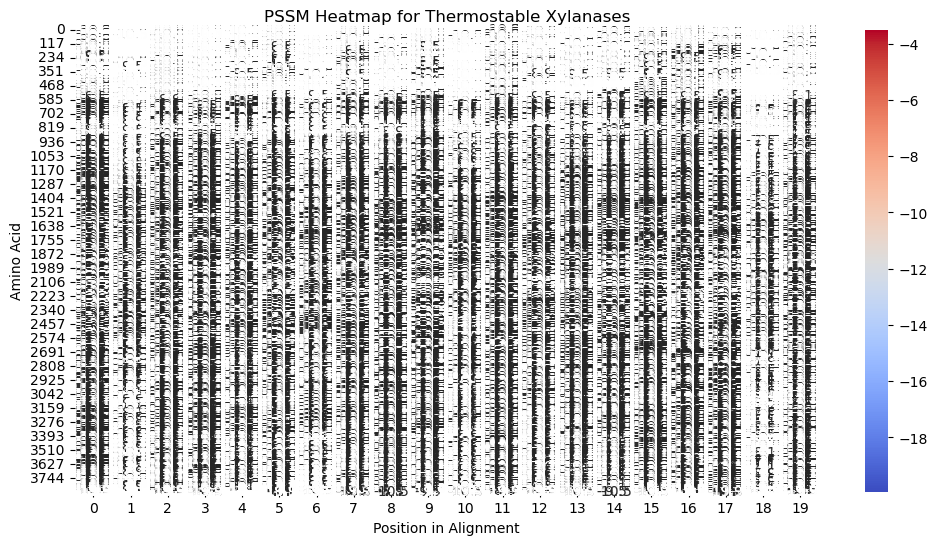

In [188]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from Bio.Align.substitution_matrices import Array

# Convert PSSM to numpy array
pssm_matrix = np.array(pssm_df)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pssm_matrix, cmap="coolwarm", annot=True, fmt=".1f", linewidths=0.5)
plt.xlabel("Position in Alignment")
plt.ylabel("Amino Acid")
plt.title("PSSM Heatmap for Thermostable Xylanases")
plt.savefig("images/pssm_heatmap.png")
plt.show()

### Distribution of Conservation Scores
This helps to understand the range of conservation scores.

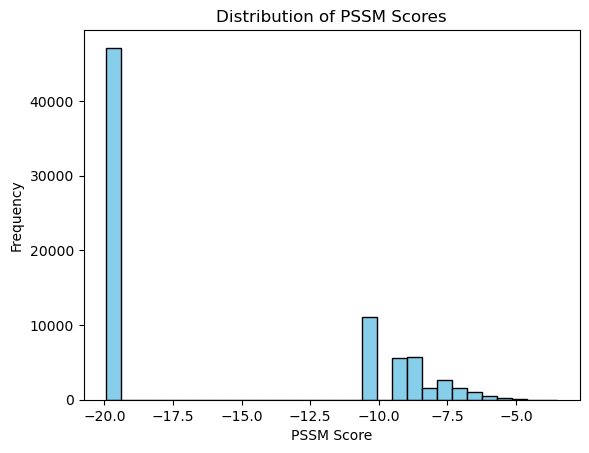

In [189]:
plt.hist(pssm_matrix.flatten(), bins=30, color="skyblue", edgecolor="black")
plt.xlabel("PSSM Score")
plt.ylabel("Frequency")
plt.title("Distribution of PSSM Scores")
plt.savefig("images/dist_pssm_score.png")
plt.show()

## Sequence Logo Visualization
A sequence logo shows conservation levels at each position.

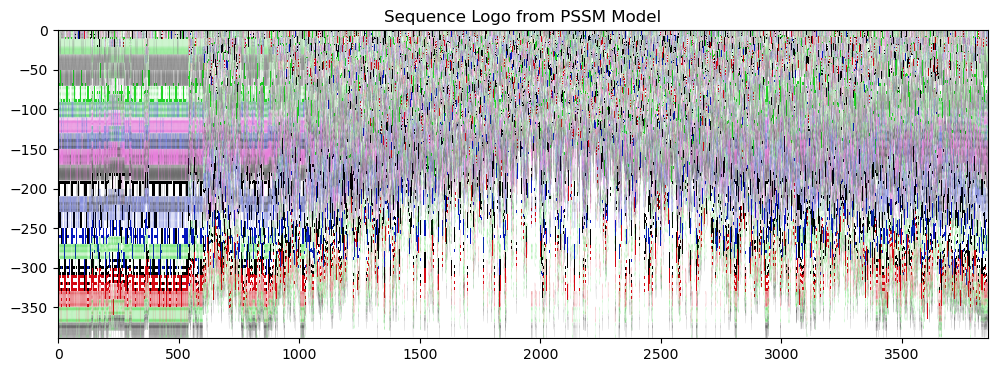

In [190]:
import logomaker
import pandas as pd

# Convert PSSM to pandas DataFrame
df_pssm = pd.DataFrame(pssm_matrix, columns=["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"])

# Generate sequence logo
logomaker.Logo(df_pssm, color_scheme="weblogo_protein", figsize=(12, 4))
plt.title("Sequence Logo from PSSM Model")
plt.savefig("images/seq_logo_pssm.png")
plt.show()

In [ ]:
!weblogo -f step3/aligned_proteins.fasta -o step3/conserved_motif.png --format PNG --size large --title "Conserved Motif in Xylanase Proteins"

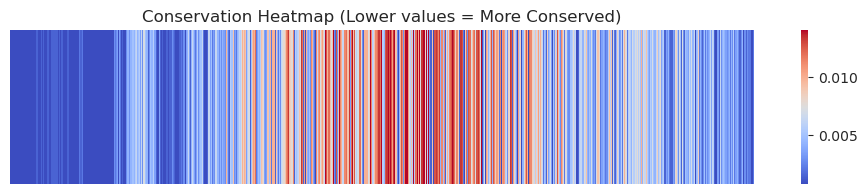

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import AlignIO

# Load aligned sequences
alignment = AlignIO.read("step3/aligned_proteins.fasta", "fasta")

# Compute conservation score for each column
num_sequences = len(alignment)
alignment_length = len(alignment[0])

conservation_scores = []
for i in range(alignment_length):
    column = [record.seq[i] for record in alignment]
    unique_residues = set(column) - {"-"}  # Exclude gaps
    score = len(unique_residues) / num_sequences
    conservation_scores.append(score)

# Create heatmap
plt.figure(figsize=(12, 2))
sns.heatmap([conservation_scores], cmap="coolwarm", xticklabels=False, yticklabels=False, cbar=True)
plt.title("Conservation Heatmap (Lower values = More Conserved)")
plt.show()


# HMM

In [179]:
!hmmbuild xylanase.hmm step3/aligned_proteins.fasta

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.4 (Aug 2023); http://hmmer.org/
# Copyright (C) 2023 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             step3/aligned_proteins.fasta
# output HMM file:                  xylanase.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     aligned_proteins      1416  3857   731   222.79  0.590 

# CPU time: 0.56u 0.00s 00:00:00.56 Elapsed: 00:00:00.56


In this step, we use HMMER’s hmmsearch tool to scan the clustered protein sequences from Step 2 against a Hidden Markov Model (HMM) of xylanases.
This helps filter sequences that match the conserved domain model.

In [182]:
!hmmsearch --tblout step3/filtered_xylanase_hmm.txt xylanase.hmm step2/clustered_proteins.fasta

# hmmsearch :: search profile(s) against a sequence database
# HMMER 3.4 (Aug 2023); http://hmmer.org/
# Copyright (C) 2023 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# query HMM file:                  xylanase.hmm
# target sequence database:        step2/clustered_proteins.fasta
# per-seq hits tabular output:     step3/filtered_xylanase_hmm.txt
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Query:       aligned_proteins  [M=731]
Scores for complete sequences (score includes all domains):
   --- full sequence ---   --- best 1 domain ---    -#dom-
    E-value  score  bias    E-value  score  bias    exp  N  Sequence     Description
    ------- ------ -----    ------- ------ -----   ---- --  --------     -----------
          0 1058.2  40.9   2.1e-280  928.4  30.7    2.2  2  k141_2357594  
    1.1e-88  294.6   3.2    1.3e-88  294.4   3.2    1.

In this step, we parse the output file from hmmsearch (filtered_xylanase_hmm.txt) to extract sequence IDs of proteins that match the xylanase HMM model.

In [183]:
import re

# Read HMMER output file
hmm_results = "step3/filtered_xylanase_hmm.txt"  # Adjust if filename is different
seq_ids = set()

with open(hmm_results, "r") as f:
    for line in f:
        if not line.startswith("#"):  # Skip comments
            cols = line.split()
            seq_id = cols[0]  # Extract the sequence ID
            seq_ids.add(seq_id)

print(f"Extracted {len(seq_ids)} sequence IDs from HMM results.")


Extracted 36 sequence IDs from HMM results.


In this step, we filter the clustered protein sequences from Step 2 and extract only those that were identified in the HMM search results.

In [185]:
from Bio import SeqIO

# Load the identified sequence IDs from HMM search
hmm_ids = set(seq_ids)

# Read clustered proteins and extract matching sequences
input_fasta = "step2/clustered_proteins.fasta"
output_fasta = "step3/final_xylanase_candidates.fasta"

with open(output_fasta, "w") as output_handle:
    for record in SeqIO.parse(input_fasta, "fasta"):
        if record.id in hmm_ids:
            SeqIO.write(record, output_handle, "fasta")

print(f"Final filtered sequences saved in {output_fasta}")

Final filtered sequences saved in step3/final_xylanase_candidates.fasta


In [186]:
from Bio import SeqIO

output_fasta = "step3/final_xylanase_candidates.fasta"

print("Final Xylanase Candidates:")
print("=" * 30)

for record in SeqIO.parse(output_fasta, "fasta"):
    print(f"ID: {record.id}")
    print(f"Length: {len(record.seq)} amino acids")
    print(f"Sequence:\n{record.seq}\n")
    print("-" * 30)


Final Xylanase Candidates:
ID: k141_966364
Length: 956 amino acids
Sequence:
VEGENIIPNGNFDSEDVSMWQAEAGEAKISTATADEPIFDDVKTYGVINSRTRSYDCIAIDVTDLVTNGSTYAFTFYAMLSDDYEGAPADQRQVDFAPYITSGGDTSYLGSYSAELSGDVSQQLTPGKWTKFSGTFKVASAGSLDKVVIRLLEQGTNYGEGDCVKGEYYVTGVSLIDMNVATGSIEEGIPALRDSMEADFGKDFIAGTSLSGSEINDSVLMSLVEKHFNAITLGNELKPDAIFGYSNDKVPMTETVHLGGEKLVVPKLDFSRAERYLDFILEWNEANPDKQRKVRGHVLVWHSQTPEWFFHENYETAKPYASVELMNLRQEWYIKSVLEHFVGSDSPYKDLFYGWDVVNEAVSDSTGTYRSDKENSSWWAVYGSEEFIKNAFVYANKYAPETLDLYYNDYNDCTPGKVEGIVKLLKAVKETEGARISGMGMQGHYDIDYPTADAFKDAARKYGEVVGKVMLTEVDLKSSSTYDGTELTLQDEYTKQAYKYKEIYDCMKELEAEGKVKVAGIVFWGVIDGNSWLQAYTGVGGGVTDGSPQCPLLFDDDYHAKPAYWAFVDPTKLAPMMHSVSILQAPVDSLDDASLIEFDDIASTFAAIWNDGQIQFKVNVVDYTDDASDKVSVYLDRYNSKSEGIKTRCVEVSRSDCEKTDTGYVAYVNVPMEEAANNVVAGFDIVITDGNDKYAFNDKTMTQESSSKYFAEMMLKPFMYIPMGKALIDGEYDDAYNGAVEVVLGNANDSPKATATAKLLWDQDFLYVYADIKDADLNKANEEPHEQDSLEVFIDETNSKADSYNAATKQYRINFDNEHSFNGDKCTEENLKTVTKKVDGGYIVEGAFKWTEVKPKEGDHIGIELQINDADASGARVGTLTWNDLTNQCWSSPSCFGTAVFTKEAEYVPTVEEAEPTEAVETA